In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile, os

zip_path = "/content/drive/MyDrive/gagandeep.zip"
extract_path = "/content/dataset"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print(" Dataset extracted.")

 Dataset extracted.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
train_dir = "/content/dataset/gagandeep/train"
val_dir = "/content/dataset/gagandeep/val"

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest')

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Found 712 images belonging to 2 classes.
Found 848 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze initial layers
for layer in base_model.layers[:600]:
    layer.trainable = False

# Unfreeze later layers for fine-tuning
for layer in base_model.layers[600:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define optimizer
optimizer = Adamax(learning_rate=1e-4)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.build((None, 224, 224, 3))

# Callbacks — No EarlyStopping used
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_resnet152_model.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Fit the model for all 51 epochs
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=51,
    callbacks=[checkpoint, lr_scheduler]  # early_stop removed
)


Epoch 1/51
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.2080 - loss: 2.1733
Epoch 1: val_loss improved from inf to 1.64780, saving model to /content/drive/MyDrive/best_resnet152_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2086 - loss: 2.1729 - val_accuracy: 0.0000e+00 - val_loss: 1.6478 - learning_rate: 1.0000e-04
Epoch 2/51
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.2334 - loss: 2.0789
Epoch 2: val_loss did not improve from 1.64780
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2335 - loss: 2.0784 - val_accuracy: 0.0000e+00 - val_loss: 1.6603 - learning_rate: 1.0000e-04
Epoch 3/51
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.2759 - loss: 1.9317
Epoch 3: val_loss did not improve from 1.64780

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2758 - loss: 1.9333 - val_accuracy: 0.0012 - val_loss: 1.6673 - learning_rate: 1.0000e-04
Epoch 4/51
23/23 ━━

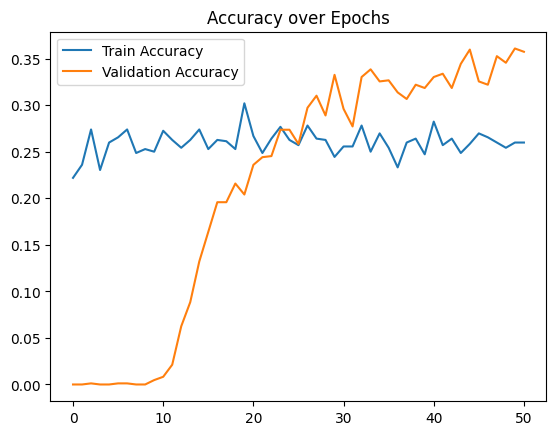

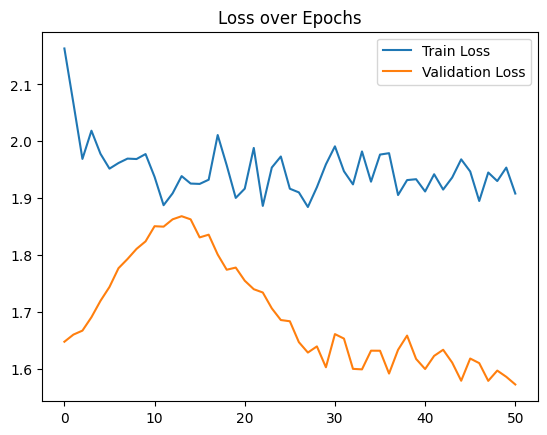

In [8]:
import matplotlib.pyplot as plt
import os

graph_dir = "/content/drive/MyDrive/diabetic_eye_results"
os.makedirs(graph_dir, exist_ok=True)

# Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.title("Accuracy over Epochs")
plt.savefig(f"{graph_dir}/accuracy_plot.png")
plt.show()

# Loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title("Loss over Epochs")
plt.savefig(f"{graph_dir}/loss_plot.png")
plt.show()


✅ Model loaded from: /content/drive/MyDrive/best_resnet152_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 805ms/step
Unique y_true: [0 1]
Unique y_pred: [0 1 2 3 4]
Valid labels: [0, 1]
Target names: ['abnormal', 'normal']

Predicted sample count per class:
abnormal: 254
normal: 210

✅ Overall Validation Accuracy: 34.43%


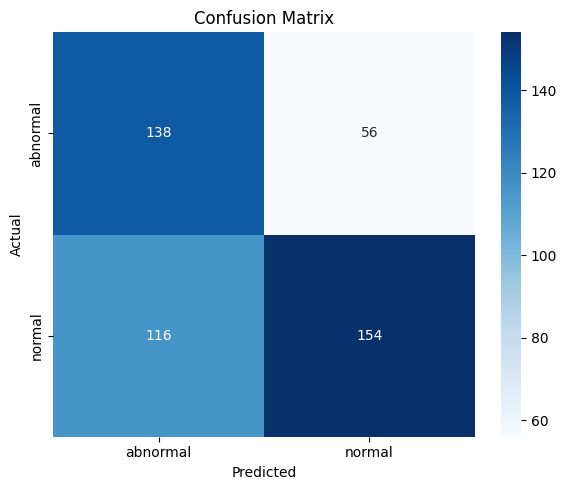


Classification Report:

              precision    recall  f1-score   support

    abnormal       0.54      0.40      0.46       348
      normal       0.73      0.31      0.43       500

   micro avg       0.63      0.34      0.45       848
   macro avg       0.64      0.35      0.45       848
weighted avg       0.66      0.34      0.44       848



In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import load_model

# === Load the trained ResNet152 model ===
model_path = "/content/drive/MyDrive/best_resnet152_model.keras"
model = load_model(model_path)
print("✅ Model loaded from:", model_path)

# === Directory to save plots ===
graph_dir = "/content/drive/MyDrive/diabetic_eye_results"
os.makedirs(graph_dir, exist_ok=True)

# === Predict on validation data ===
val_data.reset()
pred_probs = model.predict(val_data, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_data.classes

# === Get class mapping ===
class_indices = val_data.class_indices
index_to_label = {v: k for k, v in class_indices.items()}
valid_labels = sorted(index_to_label.keys())
target_names = [index_to_label[i] for i in valid_labels]

# === Debug info ===
print("Unique y_true:", np.unique(y_true))
print("Unique y_pred:", np.unique(y_pred))
print("Valid labels:", valid_labels)
print("Target names:", target_names)

# === Optional: Check class prediction counts ===
print("\nPredicted sample count per class:")
pred_counter = collections.Counter(y_pred)
for label in valid_labels:
    print(f"{index_to_label[label]}: {pred_counter.get(label, 0)}")

# === Accuracy Score ===
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Overall Validation Accuracy: {accuracy * 100:.2f}%")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred, labels=valid_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{graph_dir}/confusion_matrix.png")
plt.show()

# === Classification Report ===
print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    labels=valid_labels,
    target_names=target_names,
    zero_division=0  # Prevents warnings when precision is undefined
))


⚠️ Skipping ROC curve for Class 2 — no positive samples in y_true.
⚠️ Skipping ROC curve for Class 3 — no positive samples in y_true.
⚠️ Skipping ROC curve for Class 4 — no positive samples in y_true.


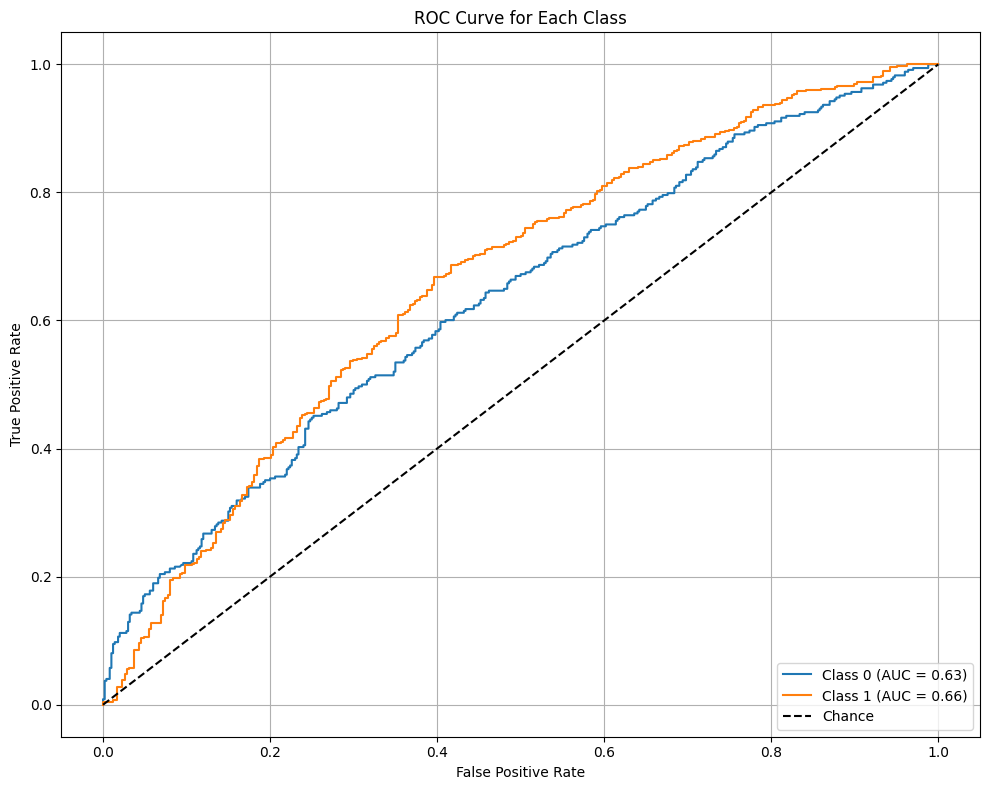


Skipped ROC for classes with no positive samples: Class 2, Class 3, Class 4
✅ ROC curve saved to: ./plots/roc_curve.png


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import os

# ---------- Required Inputs ----------
# y_true: true labels (e.g., [0, 2, 1, 4, ...]), shape = (n_samples,)
# pred_probs: predicted probabilities, shape = (n_samples, n_classes)
# labels: class names (optional, replace with your own)
# graph_dir: directory where to save plot

n_classes = 5
labels = [f'Class {i}' for i in range(n_classes)]  # Replace with actual names if needed
graph_dir = "./plots"

# Ensure output directory exists
os.makedirs(graph_dir, exist_ok=True)

# Binarize true labels for ROC computation
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Dictionaries to store ROC metrics
fpr, tpr, roc_auc = {}, {}, {}
missing_classes = []

# Compute ROC for each class
for i in range(n_classes):
    if np.sum(y_true_bin[:, i]) == 0:
        print(f"⚠️ Skipping ROC curve for {labels[i]} — no positive samples in y_true.")
        missing_classes.append(labels[i])
        continue
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ---------- Plot ROC Curves ----------
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    if i in roc_auc:
        plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Save and show plot
plot_path = os.path.join(graph_dir, "roc_curve.png")
plt.savefig(plot_path)
plt.show()

# ---------- Summary ----------
if missing_classes:
    print(f"\nSkipped ROC for classes with no positive samples: {', '.join(missing_classes)}")
print(f"✅ ROC curve saved to: {plot_path}")


In [ ]:
model.save("/content/drive/MyDrive/final_resnet152_model.keras")